# Supervised learning (Regression)

In supervised learning, the task is to infer hidden structure from
labeled data, comprised of training examples $\{(x_n, y_n)\}$.
Regression typically means the output $y$ takes continuous values.

We demonstrate with an example in Edward. A webpage version is available 
[here](http://edwardlib.org/tutorials/supervised-regression),
or as a script available at
[`examples/bayesian_linear_regression.py`](https://github.com/blei-lab/edward/blob/master/examples/bayesian_linear_regression.py)
in the Github repository.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

## Data

Simulate training and test sets of $40$ data points. They comprise of
pairs of inputs $\mathbf{x}_n\in\mathbb{R}^{10}$ and outputs
$y_n\in\mathbb{R}$. They have a linear dependence with normally
distributed noise.

In [2]:
def build_toy_dataset(N, w):
  D = len(w)
  x = np.random.normal(0.0, 2.0, size=(N, D)).astype(np.float32)
  y = np.dot(x, w) + np.random.normal(0.0, 0.01, size=N)
  return x, y


ed.set_seed(42)

N = 40  # number of data points
D = 10  # number of features

# DATA
w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

## Model

Posit the model as Bayesian linear regression (Murphy, 2012).
It assumes a linear relationship between the inputs
$\mathbf{x}\in\mathbb{R}^D$ and the outputs $y\in\mathbb{R}$.

For a set of $N$ data points $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n, y_n)\}$,
the model posits the following distributions:
\begin{align*}
  p(\mathbf{w})
  &=
  \text{Normal}(\mathbf{w} \mid \mathbf{0}, \sigma_w^2\mathbf{I}),
  \\[1.5ex]
  p(b)
  &=
  \text{Normal}(b \mid 0, \sigma_b^2),
  \\
  p(\mathbf{y} \mid \mathbf{w}, b, \mathbf{X})
  &=
  \prod_{n=1}^N
  \text{Normal}(y_n \mid \mathbf{x}_n^\top\mathbf{w} + b, \sigma_y^2).
\end{align*}
The latent variables are the linear model's weights $\mathbf{w}$ and
intercept $b$, also known as the bias.
Assume $\sigma_w^2,\sigma_b^2$ are known prior variances and $\sigma_y^2$ is a
known likelihood variance. The mean of the likelihood is given by a
linear transformation of the inputs $\mathbf{x}_n$.

Let's build the model in Edward, fixing $\sigma_w,\sigma_b,\sigma_y=1$.

In [3]:
# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(N))

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

We now turn to inferring the posterior using variational inference.
Define the variational model to be a fully factorized normal across
the weights.

In [4]:
# INFERENCE
qw = Normal(mu=tf.Variable(tf.random_normal([D])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Run variational inference with the Kullback-Leibler divergence, using a
default of $250$ iterations and $5$ latent variable samples in the algorithm.

In [5]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

Iteration   1 [  0%]: Loss = 723.772
Iteration  25 [ 10%]: Loss = 103.664
Iteration  50 [ 20%]: Loss = 69.627
Iteration  75 [ 30%]: Loss = 69.807
Iteration 100 [ 40%]: Loss = 63.521
Iteration 125 [ 50%]: Loss = 65.959
Iteration 150 [ 60%]: Loss = 64.776
Iteration 175 [ 70%]: Loss = 65.266
Iteration 200 [ 80%]: Loss = 65.851
Iteration 225 [ 90%]: Loss = 64.852
Iteration 250 [100%]: Loss = 63.913


In this case \texttt{KLqp} defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](http://edwardlib.org/tutorials/klqp).

## Criticism

A standard evaluation in regression is to calculate point-based evaluations on
held-out "testing" data. We do this first by forming the posterior predictive
distribution.

In [6]:
# CRITICISM
y_post = ed.copy(y, {w: qw, b: qb})
# This is equivalent to
# y_post = Normal(mu=ed.dot(X, qw) + qb, sigma=tf.ones(N))

With this we can evaluate various point-based quantities using the posterior
predictive.

In [7]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0300492
Mean absolute error on test data:
0.123616


The trained model makes predictions with low error
(relative to the magnitude of the output).

We can also visualize the fit by comparing data generated with the
prior to data generated with the posterior (on the first input
dimension).

In [15]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  plt.ylim([-10, 10])
  inputs = np.linspace(-8, 8, num=400, dtype=np.float32)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

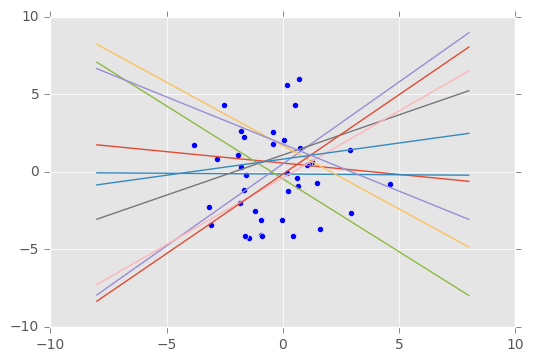

In [16]:
# Visualize samples from the prior.
visualise(X_train, y_train, w, b)

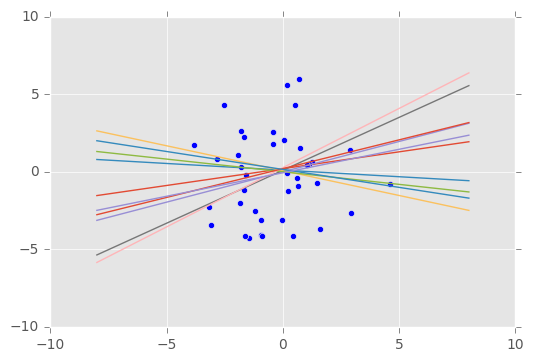

In [17]:
# Visualize samples from the posterior.
visualise(X_train, y_train, qw, qb)